*Note: only the "binary" dataset is used in the  notebook, extension to the "multi" dataset is done after converting to a Python project.*

# Part 1: Data Loading

### Import libraries

In [292]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [293]:
RANDOM_SEED = 111

### Load training data

In [294]:
%%time
X_train_binary = pd.read_csv("../data/binary/X_train.csv", header=None)
y_train_binary = pd.read_csv("../data/binary/Y_train.csv", header=None)

# Part 2: Data cleaning & create new input features

In [299]:
#todo

# Part 3. Data Visualisation & Analysis

In [298]:
X_train_binary.shape

(62210, 964)

--> Training data summary:
* There are 62,210 rows (images)
* There are 964 columns (feature):
    * first 900 columns = **HoG (Histogram of oriented Gradients)** extracted from the image (10×10 px cells, 9 orientations, 2×2 blocks).
    * next 16 columns drawn from a **normal distribution** (µ = 0.5, σ = 2)
    * last 48 columns correspond to 3 **colour histograms** extracted from the same image, one for each channel (RGB), with 16 bins per channel.

They are split into 3 different sets for further analysis and visualisation

In [201]:
X_train_HoG = X_train_binary.iloc[:, :900]
X_train_normal_dist = X_train_binary.iloc[:, 900:916]
X_train_colour_hists = X_train_binary.iloc[:, 916:]

### A. HoG (Histogram of oriented Gradients)

In [202]:
X_train_HoG.head(5)

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.108247,0.004364,0.006292,0.012344,0.125419,0.211368,0.308308,0.308308,0.047714,0.147246,...,0.086864,0.231606,0.010222,0.111093,0.036183,0.151264,0.166743,0.216403,0.231606,0.072554
1,0.245888,0.057265,0.054288,0.073985,0.245888,0.143398,0.113087,0.208721,0.173131,0.245888,...,0.018032,0.204783,0.059727,0.248219,0.248219,0.248219,0.121050,0.067763,0.037096,0.025164
2,0.218803,0.107196,0.056075,0.108894,0.143207,0.079305,0.068837,0.147177,0.089514,0.166596,...,0.232862,0.232918,0.048630,0.105441,0.028698,0.191464,0.218813,0.232918,0.232918,0.092948
3,0.199052,0.099943,0.109036,0.095986,0.218288,0.205510,0.218288,0.113477,0.128925,0.218288,...,0.161302,0.234259,0.134242,0.185844,0.164967,0.234259,0.064108,0.043844,0.234259,0.119083
4,0.234368,0.163826,0.135215,0.234368,0.219650,0.100049,0.056125,0.065694,0.148874,0.234368,...,0.243317,0.243317,0.047693,0.084939,0.123729,0.113036,0.243317,0.194783,0.243317,0.136803


In [203]:
X_train_HoG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 900 entries, 0 to 899
dtypes: float64(900)
memory usage: 427.2 MB


### B. Normal distribution

In [204]:
X_train_normal_dist.head(5)

,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915
0,-1.280041,1.238382,2.661622,-2.942723,0.256651,-0.847558,-0.144272,-3.628990,-0.317223,2.649822,5.004708,-4.185132,-0.319661,-0.403782,0.837098,0.674467
1,1.734251,3.321642,-1.756527,3.417488,-1.973764,-0.026902,2.733768,1.420462,0.212293,0.360131,1.912276,6.072646,-3.138425,-1.144073,-0.793034,-2.189273
2,-1.218798,-0.706921,-0.970352,1.446063,1.069938,4.533852,2.815861,-0.491769,-0.232733,1.098961,-0.329036,2.557483,-1.199582,0.998466,-1.331319,1.782689
3,-2.192398,-1.735968,2.031139,0.725424,-0.305053,-1.314722,-1.477061,3.391574,3.039285,-0.780832,0.132886,2.852817,4.059947,-0.462990,3.677201,-4.173188
4,-0.691028,-4.928038,-2.162437,1.651693,0.314290,2.053126,6.163571,1.326052,-2.152279,3.103169,-1.078835,-0.374443,1.339320,-0.335326,0.810662,-0.089223


In [205]:
X_train_normal_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   900     62210 non-null  float64
 1   901     62210 non-null  float64
 2   902     62210 non-null  float64
 3   903     62210 non-null  float64
 4   904     62210 non-null  float64
 5   905     62210 non-null  float64
 6   906     62210 non-null  float64
 7   907     62210 non-null  float64
 8   908     62210 non-null  float64
 9   909     62210 non-null  float64
 10  910     62210 non-null  float64
 11  911     62210 non-null  float64
 12  912     62210 non-null  float64
 13  913     62210 non-null  float64
 14  914     62210 non-null  float64
 15  915     62210 non-null  float64
dtypes: float64(16)
memory usage: 7.6 MB


### C. Colour histogram

In [206]:
X_train_colour_hists.head(5)

,916,917,918,919,920,921,922,923,924,925,...,954,955,956,957,958,959,960,961,962,963
0,570.0,957.0,448.0,214.0,179.0,227.0,243.0,197.0,152.0,95.0,...,129.0,160.0,264.0,233.0,144.0,121.0,117.0,80.0,35.0,23.0
1,26.0,99.0,263.0,450.0,656.0,552.0,525.0,349.0,252.0,186.0,...,338.0,277.0,199.0,122.0,94.0,26.0,11.0,8.0,3.0,1.0
2,9.0,42.0,143.0,324.0,668.0,494.0,447.0,407.0,368.0,344.0,...,440.0,351.0,218.0,124.0,63.0,21.0,9.0,7.0,6.0,3.0
3,11.0,83.0,104.0,486.0,1003.0,545.0,724.0,191.0,199.0,88.0,...,871.0,427.0,578.0,292.0,75.0,102.0,81.0,30.0,33.0,10.0
4,4.0,37.0,69.0,112.0,159.0,101.0,145.0,187.0,707.0,1299.0,...,166.0,285.0,605.0,1011.0,822.0,192.0,39.0,14.0,8.0,5.0


In [207]:
X_train_colour_hists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Data columns (total 48 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   916     62210 non-null  float64
 1   917     62210 non-null  float64
 2   918     62210 non-null  float64
 3   919     62210 non-null  float64
 4   920     62210 non-null  float64
 5   921     62210 non-null  float64
 6   922     62210 non-null  float64
 7   923     62210 non-null  float64
 8   924     62210 non-null  float64
 9   925     62210 non-null  float64
 10  926     62210 non-null  float64
 11  927     62210 non-null  float64
 12  928     62210 non-null  float64
 13  929     62210 non-null  float64
 14  930     62210 non-null  float64
 15  931     62210 non-null  float64
 16  932     62210 non-null  float64
 17  933     62210 non-null  float64
 18  934     62210 non-null  float64
 19  935     62210 non-null  float64
 20  936     62210 non-null  float64
 21  937     62210 non-null  float64
 22

### D. Class ID

In [288]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49768 entries, 5149 to 12116
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       49768 non-null  object
dtypes: object(1)
memory usage: 777.6+ KB


Count the occurences (and relative % distribution) of each class in the training set.

In [230]:
total_occurences = y_train_load.shape[0]
class_distribution = {
    'seal': {
        'occurences': y_train_load[0].value_counts()["seal"],
        'distribution': round(y_train_load[0].value_counts()["seal"] / total_occurences, 5)
    },
    'background': {
        'occurences': y_train_load[0].value_counts()["background"],
        'distribution': round(y_train_load[0].value_counts()["background"] / total_occurences, 5)
    }
}
class_distribution

{'seal': {'occurences': 7778, 'distribution': 0.12503},
 'background': {'occurences': 54432, 'distribution': 0.87497}}

Plot the distribution of classes in the training set in a bar chart.

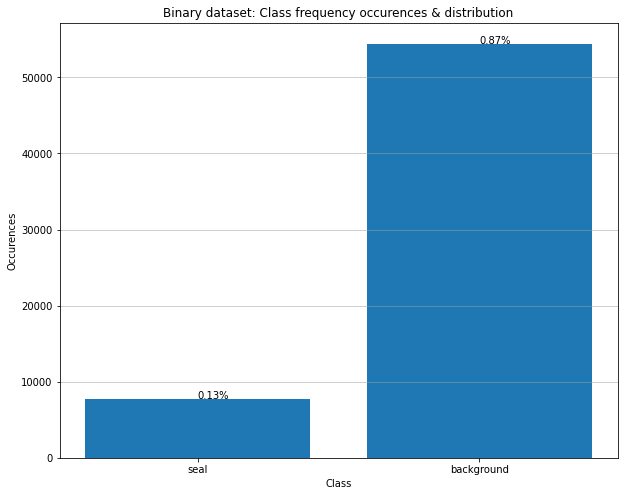

In [291]:
# Data preparation for bar chart.
data = [class_distribution['seal']['occurences'], class_distribution['background']['occurences']]
value_labels = [class_distribution['seal']['distribution'], class_distribution['background']['distribution']]
x_axis_labels = ["seal", "background"]

# Matplot lib bar chart.
plt.figure(figsize=(10, 8))
plt.xticks(range(len(data)), labels)
plt.xlabel("Class")
plt.ylabel("Occurences")
plt.title("Binary dataset: Class frequency occurences & distribution")
plt.bar(labels, data)
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.5)

# Add value labels for each bar.
for a,b in zip(labels, data):
    plt.text(a, b, "{}%".format(str(round(class_distribution[a]['distribution'], 2))))
    
# Save and display chart.
plt.savefig("binary_class_distribution.png")
plt.show()

# Part 4: Prepare inputs

### Split Train/Validation data sets

The data is already split into training and testing sets. To avoid data snooping, the testing set is ignored until the evaluation section.

However, the training set is further split between a training and a validation set to evaluate its performance during training.

A randomised 80%/20% split is used rather than stratified sampling because the dataset is large enough. According to Hands-On ML, if the dataset is large enough, the risk of introducing sampling bias is low (he mentions a set of 1,000 rows, whereas ours has 62210 rows).

The random number generator's seed is set at a fixed value to ensure that it always generates the same shuffle indices when re-running the code, ensuring reproducibility.

In [198]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train_binary, y_train_binary, test_size=0.2, random_state=RANDOM_SEED)

Confirm new training dataset sizes:

In [209]:
print("Training set split:\nTrain set size = {}\nValidation set size = {}".format(X_train.shape, X_validate.shape))

Training set split:
Train set size = (49768, 964)
Validation set size = (12442, 964)


### Data conversion

Convert class ID output to boolean format for logistic regression (True if it's a "seal", False if it's a "background").

In [290]:
y_train_seal = (y_train == "seal")

# Parts 5/6: Select & train classification models

In [ ]:
sgd_classifier = SGDClassifier(max_iter=1000, tol=1e-3, random_state=RANDOM_SEED)
sgd_classifier.fit(X_train, y_train.values.ravel())
# use values to get the values in an array, so a shape of (n,1) and then ravel() tothe convert that array shape to (n, )

In [ ]:
y_prediction = sgd_classifier.predict(X_train)
confusion_matrix(y_train, y_prediction)

# Part 7: Evaluating & comparing models performance 

### Load testing data

In [ ]:
X_test = pd.read_csv("../data/binary/X_test.csv")

# Part 8: Critical discussion of the results, approach and methods